# Linguistic development

In [45]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from nltk import word_tokenize
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, ward, fcluster
from stop_words import get_stop_words
import seaborn as sns


from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

from yellowbrick.text import UMAPVisualizer
from yellowbrick.style import set_palette

import umap
from utils import add_epoch_division, alter_epoch_division, linkage_matrix, plot_dendrogram, remove_noise_poet, text_cleaning

In [28]:
LOWERCASE = True
MAX_FEATURES = 10000
NOISELESS = True
if NOISELESS:
    PATH = "../corpora/amann_poems_noiseless.csv"
else:
    PATH = "../corpora/amann_poems.csv"
DIM_RED = False
STOP_WORDS = get_stop_words("de")

### corpus loading & vectorizing

In [29]:
corpus = text_cleaning(pd.read_csv(PATH))

In [30]:
text = corpus["poem"].values
labels = LabelEncoder().fit_transform(corpus["epoch"].values)
unique_epochs = list(np.unique(corpus["epoch"]))


vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(text)

### UMAP

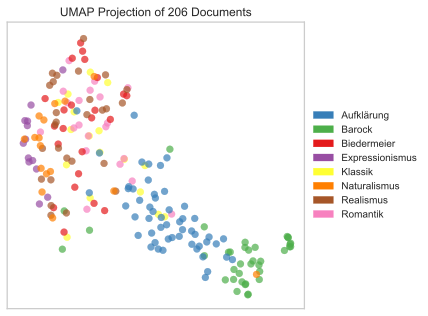

In [36]:
set_palette('set1')
umap = UMAPVisualizer(size=(480, 380))
umap.fit(vector, list(corpus.epoch))
umap.show()

In [31]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(vector)

In [56]:
def classify_svm(C=1.0, cv=3):   
    
    pipeline = Pipeline([("umap", umap.UMAP()), ("svc", LinearSVC())])
    params_grid_pipeline = {
        "umap__n_neighbors": [5, 20],
        "umap__n_components": [15, 25, 50],
        "svc__C": [1.0, 2.0, 3.0],
        "svc__max_iter": [1000, 20000],
    }


    clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline, cv=cv)
    
    clf_pipeline.fit(vector, labels)
    
    # SVM
    svm_classifier = clf_pipeline.best_estimator_

    # cross validation des Trainingsdatensatzes
    svm_scores = cross_val_score(svm_classifier, vector, labels, cv=cv)
    svm_mean = np.mean(svm_scores)

    print("Der Mittelwert der cross validation bei der Klassifizierung " 
          + f" mit SVM ist {str(np.around(svm_mean, decimals=3))}."
          + "\n")
classify_svm()

/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Der Mittelwert der cross validation bei der Klassifizierung  mit SVM ist 0.52.

